# This is an overview notebook for all the experiments in the paper 'Are Two Heads the Same as One? Identifying Disparate Treatment in Fair Neural Networks'

In this notebook, we give an overview of the experiments by recreating the figures in Chapters 3,4, and 5. To do this, we need to train a couple of networks. With `main_experiment.py` we can train networks for binary classification with different degrees of demographic parity fairness. In this notebook, we focus on the celebA dataset. You can specify

* --fairness: We can train an unconstrained model with 'unconst', or a regularized model 'DDP_squared' for regularizer (2) in our paper, or 'DDP_abs' for regularizer (3).
* --fairness_parameter: A positive float to determine the strength of the fairness regularizer if one is chosen.
* --attribute: An integer between 1 and 40 specifying which binary attribute from celebA we want to predict. See below the list of attributes.
* --protected_attribute: An integer between 1 and 40 specifying which is the protected attribute. 
* --model_name: Either 'resnet50' or 'mobilenet'. For speedup, we use mobilenet (mobilnetv3_small) in this notebook.
* --number_of_samples: For speedup we can train on a smaller subsample. 
* --stratified: We add this option to stratify the data considering both the target attribute and protected attribute. 

So we can train a mobilenet with regularizer (2) and fairness parameter 5.0 to predict 'Smiling'(31) while measuring fairness with respect to 'Male'(20) with the following command:
````
python main_experiment.py --fairness DDP_squared --fairness_parameter 5.0 --attribute 31 --protected_attribute 20 --model_name mobilenet --stratified --number_of_samples 5000
````

An unconstrained model could be trained with

````
python main_experiment.py --fairness unconst --attribute 31 --protected_attribute 20 --model_name mobilenet --stratified --number_of_samples 5000
````

We prepared a script `all_jobs.sh` with all necessary jobs, so that you can recreate the following figures.

In [1]:
from utils import plot_utils
from utils import load_data

In [2]:
load_data.get_all_celeba_attributes()

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

For the following plot, we have trained the unconstrained model and 4 regularized models ($\lambda\in\{1.0, 5.0, 10.0, 20.0\}$) to predict 'Smiling'(31) with respect to the protected attribute 'Male'(20).

Fair Models missing for parameter 10.0, prot attr Male, target Smiling
logs\celebA\target_Smiling_prot_Male\mobilenet_pretrained_on_imagenet\full_pass\fairness_DDP_squared_lambda_10.0\seed_0_learning_rate_0.0001_stratified_True/y_score_test.pkl
Fair Models missing for parameter 20.0, prot attr Male, target Smiling
logs\celebA\target_Smiling_prot_Male\mobilenet_pretrained_on_imagenet\full_pass\fairness_DDP_squared_lambda_20.0\seed_0_learning_rate_0.0001_stratified_True/y_score_test.pkl


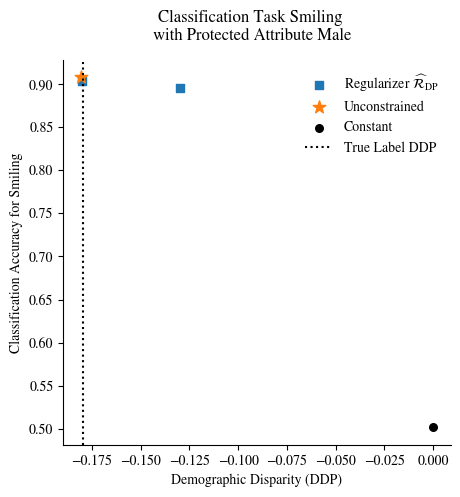

In [4]:
%matplotlib inline
plot_utils.scatter_plot_fairness_vs_accuracy(target_attr_nmb=31, 
                                      protected_attr_nmb=20, 
                                      regularizers=['DDP_squared'],
                                      fairness_parameters=[0.0, 1.0, 5.0, 10.0, 20.0],
                                      model='mobilenet')

## Protected Attribute Awareness

After we have trained these models, we freeze the network except the last layer. We finetune the last layer to predict the protected attribute that we have chosen before. To that end, we can use the same file `main_experiment.py` with the following additional arguments:
* --pretrained_on: An integer between 1 and 40 which specifies to look for a network that was trained to predict the corresponding attribute.
* --fair_backbone: Specifies if the pretrained network was trained with fairness= 'unconst', 'DDP_square', or 'DDP_abs'.
* --fair_backbone_parameter: If the pretrained network was regularized, we need to say what the fairness parameter was.

When the pretrained model was unconstrained, we can use
````
python main_experiment.py --pretrained_on 31 --fair_backbone unconst --number_of_samples 5000 --attribute 20 --model_name mobilenet --backbone_stratified
````

and for a fair pretrained model
````
python main_experiment.py --pretrained_on 31 --fair_backbone DDP_squared --fair_backbone_parameter 1.0 --number_of_samples 5000 --attribute 20 --model_name mobilenet --backbone_stratified
````

After finetuning the last layer of several fair networks to predict the protected attribute, we can compare the fairness of the pretrained model with the accuracy of predicting the protected attribute after finetuning. This corresponds to Figure 2 in the main paper. 

Fair Models missing for parameter 10.0, prot attr Male, target Smiling
logs\celebA\target_Smiling_prot_Male\mobilenet_pretrained_on_imagenet\full_pass\fairness_DDP_squared_lambda_10.0\seed_0_learning_rate_0.0001_stratified_True/y_score_test.pkl
Fair Models missing for parameter 20.0, prot attr Male, target Smiling
logs\celebA\target_Smiling_prot_Male\mobilenet_pretrained_on_imagenet\full_pass\fairness_DDP_squared_lambda_20.0\seed_0_learning_rate_0.0001_stratified_True/y_score_test.pkl


ValueError: Axis limits cannot be NaN or Inf

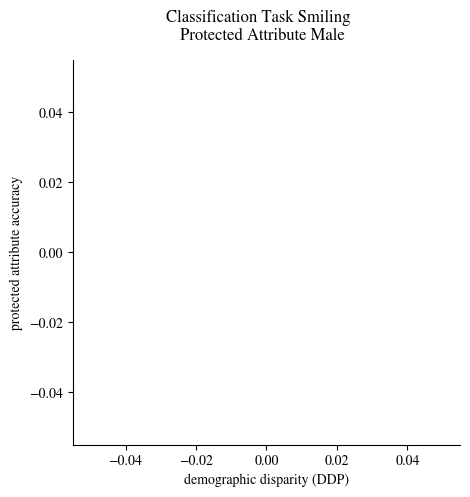

In [5]:
plot_utils.scatter_plot_fairness_vs_awareness(target_attr_nmb=31, 
                                              protected_attr_nmb=20, 
                                              regularizers=['DDP_squared'],
                                              fairness_parameters=[0.0,1.0, 5.0, 10.0, 20.0],
                                              model='mobilenet')

## Explicit Group Awareness

We can train the two-headed model described in our paper by adding the argument --two_headed.

````
python main_experiment.py --attribute 31 --protected_attribute 20 --model_name mobilenet --two_headed --number_of_samples 5000
````

After training, we find several different coefficients for the weighted sum of the two heads that have different degrees of fairness.  
````
python learn_explicit_approaches.py --model_name mobilenet --attribute 31 --protected_attribute 20
````
This function also computes the Lipton et al. approach that provides different group-dependent decision thresholds (using the true protected attribute instead of the inferred protected attribute). In the following, we see the tradeoff between fairness and acuraccy that these two explicit approaches achieve. 

In [1]:
plot_utils.scatter_plot_fairness_vs_accuracy(target_attr_nmb=31, 
                                              protected_attr_nmb=20, 
                                              explicit_approaches=['two_headed', 'lipton'],
                                              model='mobilenet')

NameError: name 'plot_utils' is not defined

## Disparate Treatment in Fair Neural Networks